In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
from typing import List
from functools import partial

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange

from mtt.models import load_model
from mtt.data import vector_to_image, stack_images, simulation_window, VectorData
from mtt.peaks import find_peaks
from mtt.utils import compute_ospa_components, compute_ospa

rng = np.random.default_rng()
sns.set_theme("paper", "ticks", font_scale=1.5)  # type: ignore


In [3]:
scale = 2
simulation_idx = rng.integers(0, 100)

with open(f"../data/test/{scale}km/simulations.pkl", "rb") as f:
    dataset_vectors: List[List[VectorData]] = pkl.load(f)


images = map(
    partial(vector_to_image, img_size=128 * scale), dataset_vectors[simulation_idx]
)
stacked = simulation_window(stack_images(images))


In [4]:
cardinality = []
for simulation in dataset_vectors:
    cardinality.append([])
    for step in simulation:
        cardinality[-1].append(len(step.target_positions))


In [5]:
simulator = dataset_vectors[0][0].simulator
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]
n_detections = (
    simulator.n_sensors * np.pi * simulator.sensors[0].range_max ** 2 / 1000**2
)


In [6]:
# Make CNN Predictions
# model, name = load_model("../models/58c6fd8a.ckpt")
# model, name = load_model("wandb://damowerko/mtt/4uc51x21")
# model, name = load_model("wandb://damowerko/mtt/rmwq3ref")
# model, name = load_model("wandb://damowerko/mtt/eiytli6p")
model, name = load_model("wandb://damowerko/mtt/e7ivqipk")
model = model.cuda()


wandb: Downloading large artifact model-e7ivqipk:best_k, 102.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [7]:
filt_idx = -1
method = "kmeans"
n_peaks_scale = 1.0

with torch.no_grad():
    x = torch.stack([d.sensor_images for d in stacked], dim=0)
    output_images = model(x.cuda())
    pred_img = output_images.clamp(min=0).cpu().numpy() * n_peaks_scale

n = pred_img.shape[0]
width = simulator.simulation_width
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions_cnn = []
for i in trange(n):
    predictions_cnn.append(
        find_peaks(pred_img[i][filt_idx], width=window, method=method).means
    )

cardinality_cnn = pred_img.sum(axis=(-1, -2)).mean().item()
print(f"Mean cardinality estimate: {cardinality_cnn:.2f}")
cardinality_truth = np.mean(
    [len(d.info[filt_idx]["target_positions"]) for d in stacked]
)
print(f"Mean cardinality truth: {cardinality_truth}")
print(f"Ratio {cardinality_truth / cardinality_cnn:.2f}")


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]

Mean cardinality estimate: 44.46
Mean cardinality truth: 46.95
Ratio 1.06


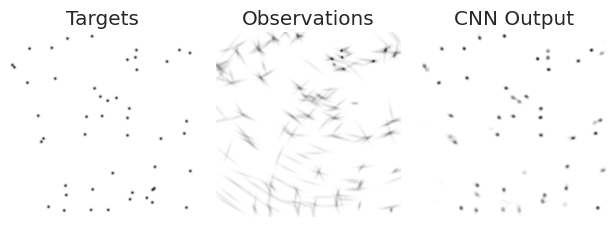

In [8]:
idx = simulation_idx
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(
    stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="gray_r"
)
axs[0].set_title("Targets")
axs[1].imshow(
    stacked[idx][0][filt_idx].cpu(), extent=extent, origin="lower", cmap="gray_r"
)
axs[1].set_title("Observations")
axs[2].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="gray_r")
axs[2].set_title("CNN Output")
for ax in axs:
    ax.axis("off")
plt.savefig("../figures/images.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


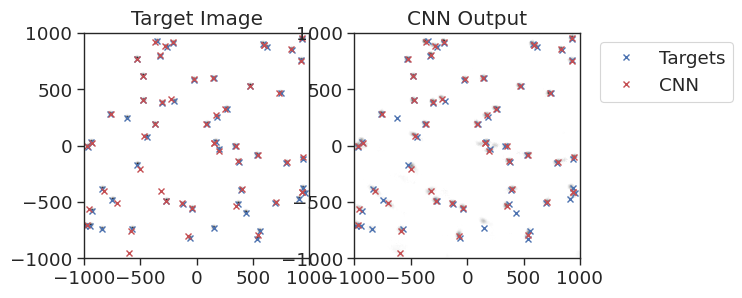

In [9]:
idx = 41

fig, axs = plt.subplots(1, 2)
target_pos = stacked[idx][2][filt_idx]["target_positions"]
mu, *_ = find_peaks(pred_img[idx][filt_idx], width=window, method=method)

axs[0].imshow(
    stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="gray_r"
)
axs[0].set_title("Target Image")

axs[1].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="gray_r")
axs[1].set_title("CNN Output")

for ax in axs:
    ax.plot(*target_pos.T, "bx", label="Targets")
    ax.plot(*mu.T, "rx", label="CNN")
    ax.set_xlim(-window / 2, window / 2)
    ax.set_ylim(-window / 2, window / 2)
# legend to right of axes
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [10]:
mean_energy = np.mean(
    [pos_img[1].cpu().clamp(min=0).sum(dim=[-1, -2]) for _, pos_img, _ in stacked]
)
mean_cardinality = np.mean(
    [len(info["target_positions"]) for _, _, infos in stacked for info in infos]
)
mean_energy, mean_cardinality


(50.322845, 48.5705)

In [11]:
card_true = np.array([len(d[2][filt_idx]["target_positions"]) for d in stacked])
card_cnn = np.array([len(p) for p in predictions_cnn])
card_img = pred_img.sum(axis=(-1, -2))


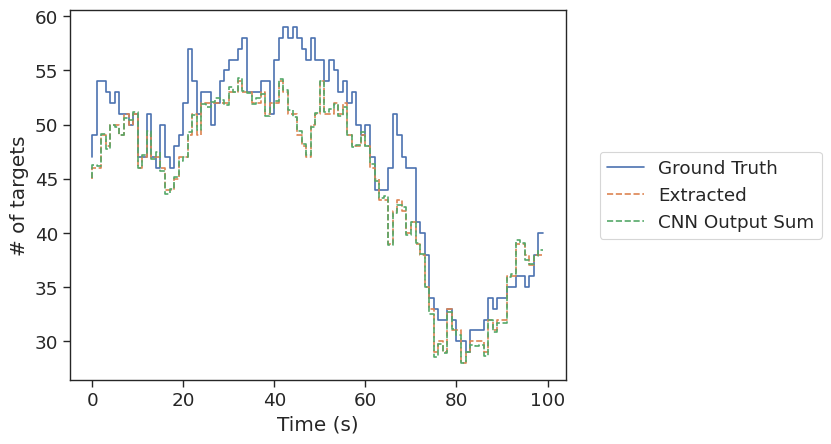

In [12]:
# plot cardinality
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_cnn, label="Extracted", linestyle="dashed")
plt.step(np.arange(n), card_img, label="CNN Output Sum", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("# of targets")
# legend to the right of axis
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.savefig("../figures/cardinality.pdf")


Mean OSPA: 148.52m ± 30.83m
Mean OSPA (Position): 86.14m ± 30.77m
Mean OSPA (Cardinality): 109.19m ± 52.14m


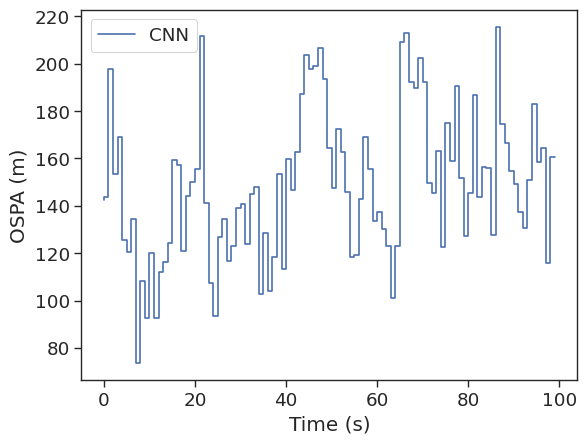

In [13]:
ospa_cnn = []
ospa_cnn_components = []
for idx in range(n):
    sensor_img, target_img, info = stacked[idx]
    target_positions = info[-1]["target_positions"]
    ospa_cnn += [compute_ospa(target_positions, predictions_cnn[idx], 500, p=2)]
    ospa_cnn_components += [
        compute_ospa_components(target_positions, predictions_cnn[idx], 500, p=2)
    ]

ospa_cnn_components = np.array(ospa_cnn_components)
print(f"Mean OSPA: {np.mean(ospa_cnn):.2f}m \u00B1 {np.std(ospa_cnn):.2f}m")
print(
    f"Mean OSPA (Position): {np.mean(ospa_cnn_components[:,0]):.2f}m \u00B1 {np.std(ospa_cnn_components[:,0]):.2f}m"
)
print(
    f"Mean OSPA (Cardinality): {np.mean(ospa_cnn_components[:,1]):.2f}m \u00B1 {np.std(ospa_cnn_components[:,1]):.2f}m"
)

plt.figure()
plt.step(np.arange(n), ospa_cnn, label="CNN")
# plt.step(np.arange(n), ospa_cnn_components[:,0], label="CNN (Position)")
# plt.step(np.arange(n), ospa_cnn_components[:,1], label="CNN (Cardinality)")
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../figures/ospa.pdf")


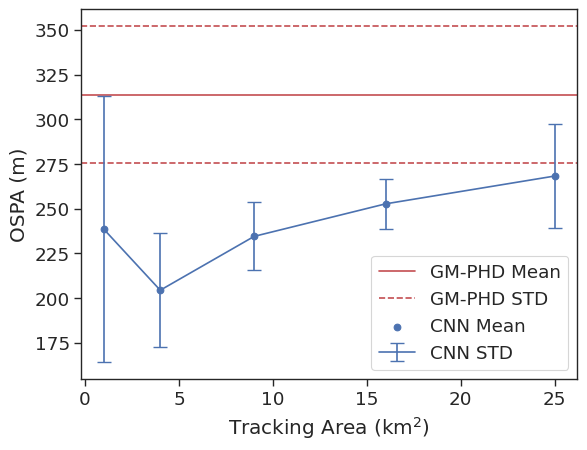

In [14]:
# plot CNN performance generalization
df = pd.DataFrame(
    dict(
        width=[1, 2, 3, 4, 5],
        cnn_mean=[238.45, 204.34, 234.48, 252.68, 268.24],
        cnn_std=[74.40, 31.97, 19.04, 14.05, 29.04],
    )
)
phd_std = 76.58
phd_mean = 313.78

plt.figure()
plt.axhline(phd_mean, color="r", label="GM-PHD Mean")
plt.axhline(phd_mean + phd_std / 2, color="r", linestyle="--", label="GM-PHD STD")
plt.axhline(phd_mean - phd_std / 2, color="r", linestyle="--")
plt.scatter(df.width**2, df.cnn_mean, label="CNN Mean")
plt.errorbar(df.width**2, df.cnn_mean, yerr=df.cnn_std, capsize=5, label="CNN STD")
plt.legend()
plt.xlabel("Tracking Area (km$^2$)")
plt.ylabel("OSPA (m)")
plt.savefig("../figures/transfer.pdf")
